# Intro to RAPIDS using the New York City Yellow Taxi Data 
light on Data Science, heavy on comparisons.

This notebook is for the The Toronto Machine Learning Summit, Nov 16 -29, 2020

![TMLS](./img/TMLS.png)

This notebook includes

* cudf - for basic ETL and some __statistical analysis__ 
* cuml - for __machine learning__
* cugraph - for some __graph analysis__
* cuxfilter - for __visualization__


----
# Setup

In [1]:
# load the libraries
import cudf

import numpy as np
import pandas as pd
import math

import os
import gc

from collections import OrderedDict
import argparse
import datetime
import time

In [2]:
try: 
    import tqdm
except ModuleNotFoundError:
    os.system('pip install tqdm')
    import tqdm

In [3]:
# Let's use Unified Memory (aka managed memory) so that we try and avoid OOM errors 
# start by importing the RAPIDS Memory Manager and then reinitializing with managed memory turn on
import rmm

rmm.reinitialize(   
    managed_memory=True,        # Use managed memory, this allows for oversubscription of the GPU
    pool_allocator=False,       # default is False
    devices=0,                  # GPU device IDs to register. By default, registers only GPU 0.
)

## Download the data

In [4]:
top_dir = "./"
data_dir = "./nyctaxi"

In [5]:
# Download Taxi data

if os.path.exists(data_dir) == False:
    import nyctaxi_data

    print("downloading data")
    nyctaxi_data.download_nyctaxi_data(["2016"], top_dir)
    

downloading data
- Downloading https://storage.googleapis.com/anaconda-public-data/nyc-taxi/csv/2016/yellow_tripdata_2016-01.csv
100%|██████████| 1708674492/1708674492 [01:10<00:00, 24186120.33it/s]
- Downloading https://storage.googleapis.com/anaconda-public-data/nyc-taxi/csv/2016/yellow_tripdata_2016-02.csv
100%|██████████| 1783554554/1783554554 [01:19<00:00, 22471869.00it/s]
- Downloading https://storage.googleapis.com/anaconda-public-data/nyc-taxi/csv/2016/yellow_tripdata_2016-03.csv
100%|██████████| 1914669757/1914669757 [01:29<00:00, 21284164.46it/s]
- Downloading https://storage.googleapis.com/anaconda-public-data/nyc-taxi/csv/2016/yellow_tripdata_2016-04.csv
100%|██████████| 1872015980/1872015980 [01:09<00:00, 27119216.98it/s]
- Downloading https://storage.googleapis.com/anaconda-public-data/nyc-taxi/csv/2016/yellow_tripdata_2016-05.csv
100%|██████████| 1858526595/1858526595 [01:26<00:00, 21594887.57it/s]
- Downloading https://storage.googleapis.com/anaconda-public-data/nyc-tax

----

# cuDF - Accelerated Data Frame 

In [6]:
# get a list of files
data_path = top_dir + "nyctaxi/2016"

files = []

for f in sorted(os.listdir(data_path)):
    if f[0:6] != 'yellow':
        continue
        
    fname = os.path.join(data_path, f)
            
    files.append(fname)


In [7]:
files

['./nyctaxi/2016/yellow_tripdata_2016-01.csv',
 './nyctaxi/2016/yellow_tripdata_2016-02.csv',
 './nyctaxi/2016/yellow_tripdata_2016-03.csv',
 './nyctaxi/2016/yellow_tripdata_2016-04.csv',
 './nyctaxi/2016/yellow_tripdata_2016-05.csv',
 './nyctaxi/2016/yellow_tripdata_2016-06.csv']

In [8]:
!du -sh $data_path

11G	./nyctaxi/2016


## Loading data performance test

In [9]:
def read_pandas(f):
    start_t = time.time()
    df = pd.read_csv(f)
    end_t = time.time() - start_t

    return df, end_t

In [10]:
def read_cudf(f):
    start_t = time.time()
    df = cudf.read_csv(f)
    end_t = time.time() - start_t

    return df, end_t

In [11]:
_ = read_pandas(files[0])

In [12]:
# Load data with Pandas

data = []

start_t = time.time()

for f in files:
    print("\treading " + f, end = '')
    df, t = read_pandas(f)
    print(" ... in time of " + str(t) + " seconds")
    data.append(df)
  
taxi_pdf = pd.concat(data)

end_t = time.time()

print(f"loaded {len(taxi_pdf):,} records in {(end_t - start_t):2f}  seconds")

del data

	reading ./nyctaxi/2016/yellow_tripdata_2016-01.csv ... in time of 21.91859483718872 seconds
	reading ./nyctaxi/2016/yellow_tripdata_2016-02.csv ... in time of 22.271501779556274 seconds
	reading ./nyctaxi/2016/yellow_tripdata_2016-03.csv ... in time of 23.896158456802368 seconds
	reading ./nyctaxi/2016/yellow_tripdata_2016-04.csv ... in time of 22.499367475509644 seconds
	reading ./nyctaxi/2016/yellow_tripdata_2016-05.csv ... in time of 22.86159086227417 seconds
	reading ./nyctaxi/2016/yellow_tripdata_2016-06.csv ... in time of 21.273421049118042 seconds
loaded 69,406,520 records in 146.848941  seconds


In [13]:
# Load data with RAPIDS cuDF

data = []

start_t = time.time()

for f in files:
    print("\treading " + f, end = '')
    df, t = read_cudf(f)
    print(" ... in time of " + str(t)+ " seconds")
    data.append(df)

taxi_gdf = cudf.concat(data)

end_t = time.time()

print(f"loaded {len(taxi_gdf):,} records in {(end_t - start_t):2f}  seconds")

del data

	reading ./nyctaxi/2016/yellow_tripdata_2016-01.csv ... in time of 2.2414679527282715 seconds
	reading ./nyctaxi/2016/yellow_tripdata_2016-02.csv ... in time of 1.4974064826965332 seconds
	reading ./nyctaxi/2016/yellow_tripdata_2016-03.csv ... in time of 1.5875179767608643 seconds
	reading ./nyctaxi/2016/yellow_tripdata_2016-04.csv ... in time of 1.5843276977539062 seconds
	reading ./nyctaxi/2016/yellow_tripdata_2016-05.csv ... in time of 1.5822975635528564 seconds
	reading ./nyctaxi/2016/yellow_tripdata_2016-06.csv ... in time of 1.4630935192108154 seconds
loaded 69,406,520 records in 12.100809  seconds


In [14]:
taxi_gdf.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,40.732407,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8


## Sort Comparisons - Single Field

In [15]:
%%time
sp = taxi_pdf.sort_values(by='trip_distance',ascending=False)

CPU times: user 55.4 s, sys: 5.82 s, total: 1min 1s
Wall time: 1min 1s


In [16]:
sp.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
8340109,1,2016-03-07 19:57:50,2016-03-07 20:16:21,1,19072628.8,-73.995796,40.761204,1,Y,-73.995789,40.761208,2,2.5,1.0,0.5,0.00,0.0,0.3,4.30
9860101,1,2016-05-26 00:00:48,2016-05-26 00:13:46,1,12000004.5,-73.950768,40.711014,1,N,-73.999924,40.677673,1,17.5,0.5,0.5,4.00,0.0,0.3,22.80
10662053,1,2016-05-28 04:53:05,2016-05-28 05:13:04,1,12000003.9,-73.990784,40.750755,1,N,-73.959198,40.688946,1,20.5,0.5,0.5,5.45,0.0,0.3,27.25
3963837,1,2016-02-13 09:20:43,2016-02-13 09:22:00,3,11658534.3,-73.945442,40.751583,1,N,-73.945442,40.751583,2,2.5,0.0,0.5,0.00,0.0,0.3,3.30
10213817,1,2016-03-26 17:24:14,2016-03-26 17:33:23,2,8330083.2,-74.004929,40.730019,1,N,-73.994614,40.750378,2,9.0,0.0,0.5,0.00,0.0,0.3,9.80


In [17]:
%%time
sg = taxi_gdf.sort_values(by='trip_distance',ascending=False)

CPU times: user 3.63 s, sys: 30.9 ms, total: 3.66 s
Wall time: 3.68 s


In [18]:
sg.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
8340109,1,2016-03-07 19:57:50,2016-03-07 20:16:21,1,19072628.8,-73.995796,40.761204,1,Y,-73.995789,40.761208,2,2.5,1.0,0.5,0.00,0.0,0.3,4.30
9860101,1,2016-05-26 00:00:48,2016-05-26 00:13:46,1,12000004.5,-73.950768,40.711014,1,N,-73.999924,40.677673,1,17.5,0.5,0.5,4.00,0.0,0.3,22.80
10662053,1,2016-05-28 04:53:05,2016-05-28 05:13:04,1,12000003.9,-73.990784,40.750755,1,N,-73.959198,40.688946,1,20.5,0.5,0.5,5.45,0.0,0.3,27.25
3963837,1,2016-02-13 09:20:43,2016-02-13 09:22:00,3,11658534.3,-73.945442,40.751583,1,N,-73.945442,40.751583,2,2.5,0.0,0.5,0.00,0.0,0.3,3.30
10213817,1,2016-03-26 17:24:14,2016-03-26 17:33:23,2,8330083.2,-74.004929,40.730019,1,N,-73.994614,40.750378,2,9.0,0.0,0.5,0.00,0.0,0.3,9.80


## Group By - Single Column 

In [19]:
%%time
gbp = taxi_pdf.groupby('passenger_count').count()

CPU times: user 23.1 s, sys: 1.31 s, total: 24.4 s
Wall time: 24.4 s


In [20]:
gbp.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
passenger_count,,,,,,,,,,,,,,,,,,
0,10897,10897,10897,10897,10897,10897,10897,10897,10897,10897,10897,10897,10897,10897,10897,10897,10897,10897
1,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874
2,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593
3,2846266,2846266,2846266,2846266,2846266,2846266,2846266,2846266,2846266,2846266,2846266,2846266,2846266,2846266,2846266,2846266,2846266,2846266
4,1350730,1350730,1350730,1350730,1350730,1350730,1350730,1350730,1350730,1350730,1350730,1350730,1350730,1350730,1350730,1350730,1350730,1350730


In [21]:
%%time
gbg = taxi_gdf.groupby('passenger_count').count()

CPU times: user 3.52 s, sys: 541 ms, total: 4.06 s
Wall time: 4.06 s


In [22]:
gbg.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
passenger_count,,,,,,,,,,,,,,,,,,
8,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141
6,2277816,2277816,2277816,2277816,2277816,2277816,2277816,2277816,2277816,2277816,2277816,2277816,2277816,2277816,2277816,2277816,2277816,2277816
2,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593,9981593
7,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149
1,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874,49251874


## Fun with Data

In [23]:
%%time
print(f"Max fare was ${taxi_pdf['fare_amount'].max():,}")

Max fare was $628,544.74
CPU times: user 161 ms, sys: 0 ns, total: 161 ms
Wall time: 158 ms


In [24]:
%%time
print(f"Max fare was ${taxi_gdf['fare_amount'].max():,}")

Max fare was $628,544.74
CPU times: user 18.6 ms, sys: 3.89 ms, total: 22.5 ms
Wall time: 37.8 ms


In [25]:
# looking at that huge fare
maxf = taxi_gdf['fare_amount'].max()
taxi_gdf.query('fare_amount == @maxf')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
10199130,1,2016-06-30 09:21:03,2016-06-30 09:21:03,1,0.0,-73.872955,40.773994,1,N,0.0,0.0,2,628544.74,488.24,0.5,0.0,0.0,0.3,629033.78
10203011,1,2016-06-30 09:28:53,2016-06-30 09:28:53,1,0.0,-73.928604,40.787613,1,N,0.0,0.0,2,628544.74,488.24,0.5,0.0,0.0,0.3,629033.78


In [26]:
print(f"Farthest trip was {taxi_gdf['trip_distance'].max():,} miles")

Farthest trip was 19,072,628.8 miles


In [27]:
# How long did it take to drive that distance?
maxd= taxi_gdf['trip_distance'].max()
taxi_gdf.query('trip_distance == @maxd')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
8340109,1,2016-03-07 19:57:50,2016-03-07 20:16:21,1,19072628.8,-73.995796,40.761204,1,Y,-73.995789,40.761208,2,2.5,1.0,0.5,0.0,0.0,0.3,4.3


### Changing data types

In [28]:
# change some data types
taxi_gdf = taxi_gdf.astype({'tpep_pickup_datetime':'datetime64[ms]', 'tpep_dropoff_datetime':'datetime64[ms]'})

### Filtering data

In [29]:
# filter out records with missing or outlier values
query_frags = ("(fare_amount > 0 and fare_amount < 500) " +
        "and (passenger_count > 0 and passenger_count < 6) " +
        "and (pickup_longitude > -75 and pickup_longitude < -73) " +
        "and (dropoff_longitude > -75 and dropoff_longitude < -73) " +
        "and (pickup_latitude > 40 and pickup_latitude < 42) " +
        "and (dropoff_latitude > 40 and dropoff_latitude < 42)" +
        "and (pickup_latitude != dropoff_latitude) " +
        "and (pickup_longitude != dropoff_longitude)"
    )

taxi_gdf = taxi_gdf.query(query_frags)

### Add some new features

In [30]:
# easier to reference time by YYYY MM DD version a time stamps
taxi_gdf['hour']  = taxi_gdf['tpep_pickup_datetime'].dt.hour
taxi_gdf['year']  = taxi_gdf['tpep_pickup_datetime'].dt.year
taxi_gdf['month'] = taxi_gdf['tpep_pickup_datetime'].dt.month
taxi_gdf['day']   = taxi_gdf['tpep_pickup_datetime'].dt.day
taxi_gdf['diff']  = taxi_gdf['tpep_dropoff_datetime'].astype('int64') - taxi_gdf['tpep_pickup_datetime'].astype('int64')

In [31]:
def day_of_the_week_kernel(day, month, year, day_of_week):
    for i, (d_1, m_1, y_1) in enumerate(zip(day, month, year)):
        if month[i] < 3:
            shift = month[i]
        else:
            shift = 0
        Y = year[i] - (month[i] < 3)
        y = Y - 2000
        c = 20
        d = day[i]
        m = month[i] + shift + 1
        day_of_week[i] = (d + math.floor(m * 2.6) + y + (y // 4) + (c // 4) - 2 * c) % 7
        
taxi_gdf = taxi_gdf.apply_rows(
        day_of_the_week_kernel
        , incols = ['day', 'month', 'year']
        , outcols = {'day_of_week': np.int32}
        , kwargs = {}
    )

In [32]:
taxi_gdf.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,hour,year,month,day,diff,day_of_week
0,2,2016-01-01,2016-01-01,2,1.10,-73.990372,40.734695,1,N,-73.981842,...,0.0,0.0,0.3,8.8,0,2016,1,1,0,5
1,2,2016-01-01,2016-01-01,5,4.90,-73.980782,40.729912,1,N,-73.944473,...,0.0,0.0,0.3,19.3,0,2016,1,1,0,5
2,2,2016-01-01,2016-01-01,1,10.54,-73.984550,40.679565,1,N,-73.950272,...,0.0,0.0,0.3,34.3,0,2016,1,1,0,5
3,2,2016-01-01,2016-01-01,1,4.75,-73.993469,40.718990,1,N,-73.962242,...,0.0,0.0,0.3,17.3,0,2016,1,1,0,5
4,2,2016-01-01,2016-01-01,3,1.76,-73.960625,40.781330,1,N,-73.977264,...,0.0,0.0,0.3,8.8,0,2016,1,1,0,5


---

## Basic Statistical Data Science

### Look at some feature - by Hour

<AxesSubplot:xlabel='hour'>

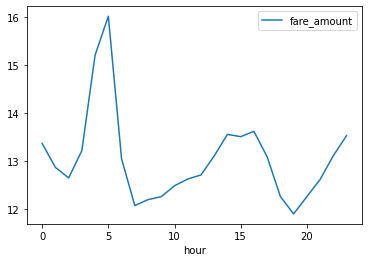

In [33]:
# 1) Let's look at a plot of fare by hour
%matplotlib inline
taxi_gdf.groupby('hour').fare_amount.mean().to_pandas().sort_index().plot(legend=True)

<AxesSubplot:xlabel='hour'>

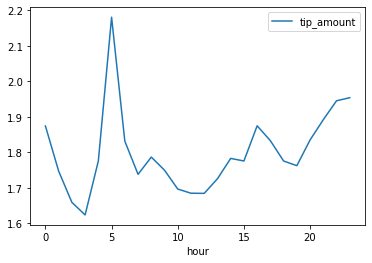

In [34]:
# 2) Tips by hour
%matplotlib inline
taxi_gdf.groupby('hour').tip_amount.mean().to_pandas().sort_index().plot(legend=True)

<AxesSubplot:xlabel='hour'>

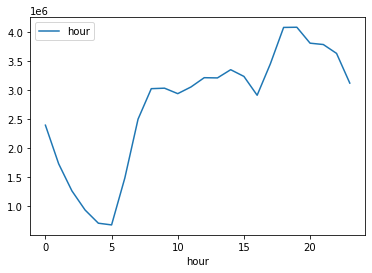

In [40]:
# 3) Number of taxi rides by Hour
%matplotlib inline
taxi_gdf['hour'].groupby(taxi_gdf['hour']).count().to_pandas().sort_index().plot(legend=True)

<AxesSubplot:xlabel='day_of_week'>

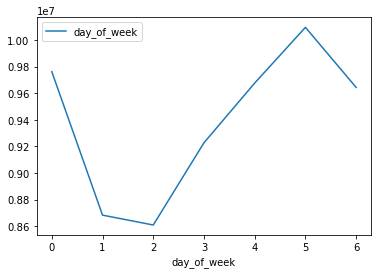

In [41]:
# Look at what days are the busiest
%matplotlib inline
taxi_gdf.groupby('day_of_week').day_of_week.count().to_pandas().sort_index().plot(legend=True)

<AxesSubplot:xlabel='day_of_week'>

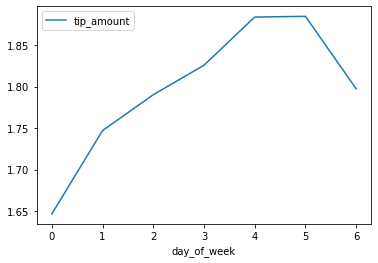

In [42]:
# What days have the best tips
%matplotlib inline
taxi_gdf.groupby('day_of_week').tip_amount.mean().to_pandas().sort_index().plot(legend=True)

# Dropping Columns

In [43]:
taxi_gdf = taxi_gdf.drop('store_and_fwd_flag', axis=1)

In [44]:
taxi_gdf.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ms]
tpep_dropoff_datetime    datetime64[ms]
passenger_count                   int64
trip_distance                   float64
pickup_longitude                float64
pickup_latitude                 float64
RatecodeID                        int64
dropoff_longitude               float64
dropoff_latitude                float64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
hour                              int16
year                              int16
month                             int16
day                               int16
diff                              int64
day_of_week                       int32
dtype: object

---

# cuML - Accelerated Machine Learning

### In Corey's talk

---
# cuGraph - Accelerated Graph Analytics

We need vertex IDs to be integer values but what we have are lat-long pairs (float64).  There are two way that we can address the issue. The hard way and an easy way

In [45]:
import cugraph

In [46]:
taxi_subset = taxi_gdf[['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'trip_distance']].reset_index()
taxi_subset['count'] = 1
del taxi_gdf

### Create vertices and edges the hard way

In [47]:
# create node ID from lat-long combinatiuons
nodes = [
      taxi_subset[['pickup_longitude', 'pickup_latitude']].drop_duplicates().rename(columns={'pickup_longitude': 'long', 'pickup_latitude': 'lat'})
    , taxi_subset[['dropoff_longitude', 'dropoff_latitude']].drop_duplicates().rename(columns={'dropoff_longitude': 'long', 'dropoff_latitude': 'lat'})
]

In [48]:
nodes = cudf.concat(nodes).drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
nodes.head(5)

,id,long,lat
0,0,-74.997330,41.879631
1,1,-74.988434,40.049549
2,2,-74.979439,41.489216
3,3,-74.977318,40.319294
4,4,-74.973709,40.591049


In [49]:
print('Total number of geo points in the dataset: {0:,}'.format(len(nodes)))

Total number of geo points in the dataset: 49,805,004


In [50]:
edges = (
    taxi_subset[['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'trip_distance']]
    .drop_duplicates()
    .rename(columns={'pickup_longitude': 'long', 'pickup_latitude': 'lat'})
    .merge(nodes, on=['lat', 'long'])
    .rename(columns={'long': 'pickup_longitude', 'lat': 'pickup_latitude', 'id': 'pickup_id', 'dropoff_longitude': 'long', 'dropoff_latitude': 'lat'})
    .merge(nodes, on=['lat', 'long'])
    .rename(columns={'long': 'dropoff_longitude', 'lat': 'dropoff_latitude', 'id': 'dropoff_id'})
)[['pickup_id', 'dropoff_id', 'trip_distance']]

edges.head(5)

,pickup_id,dropoff_id,trip_distance
0,77059,76070,1.99
1,77067,77925,2.70
2,77071,82151,1.24
3,77076,76932,0.00
4,77083,71558,1.58


In [51]:
len(edges)

65700225

In [52]:
g = cugraph.Graph()
g.from_cudf_edgelist(edges, source='pickup_id', destination='dropoff_id')

## Pagerank

In [53]:
%%time
page = cugraph.pagerank(g, alpha=.85, max_iter=1000, tol=1.0e-05)

CPU times: user 3.21 s, sys: 562 ms, total: 3.77 s
Wall time: 3.84 s


In [54]:
page.sort_values(by='pagerank', ascending=False).head(5).to_pandas()

,pagerank,vertex
16688,0.000003,48343377
16697,0.000003,49670386
16689,0.000003,48342703
18231,0.000003,49670396
16690,0.000003,48342697


## Now the easy way

In [55]:
g2 = cugraph.Graph()
g2.from_cudf_edgelist(taxi_subset, 
                      source=['pickup_longitude', 'pickup_latitude'], 
                      destination=['dropoff_longitude', 'dropoff_latitude'], 
                      edge_attr='count',
                      renumber=True)

In [56]:
page = cugraph.pagerank(g2, alpha=.85, max_iter=1000, tol=1.0e-05)
page.sort_values(by='pagerank', ascending=False).head(5).to_pandas()

,pagerank,0_vertex,1_vertex
14944,0.000003,-73.870872,40.773739
14959,0.000003,-73.776703,40.645370
14945,0.000003,-73.870888,40.773762
5319,0.000003,-73.776703,40.645409
14946,0.000003,-73.870888,40.773739


---